-----
# **[RNN과 LSTM을 활용한 로이터 뉴스 분류]**
-----

In [1]:
# 각종 라이브러리 가져오기 
import tensorflow as tf

from tensorflow.keras.models import Sequential             
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional #양방향  ,문자열(장기기억)

from tensorflow.keras.datasets.reuters import load_data   

from tensorflow.keras.preprocessing import sequence #시퀀스 데이터 처리 함수
from tensorflow.keras.utils import to_categorical #원핫 인코딩 = 4개의 클래스 
from  tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences #시퀀스 -> 동일한 크기 -> 패딩

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split 

In [2]:
# 난수 생성 시의 시드 값 설정
seed = 0
np.random.seed(seed)

# 1. 데이터 수집


## 1.1 데이터 적재(load)

In [3]:
(훈련용_X, 훈련용_y), (테스트용_X, 테스트용_y) = load_data(num_words=100000, test_split=0.2)
#num_words=100000,-> 1~ 100000 에 해당하는 단어만 추출  
#전체 뉴스 기사에서 20%만 테스트용으로 사용 
#훈련용 뉴스기사 :  8982   
#테스트용 뉴스기사 :  2246 
# 카테고리  :  46 

2110848/2110848 [==============================] - 0s 0us/step


In [4]:
pd.DataFrame(훈련용_X)  # 8982에 해당하는 뉴스 기사  

,0
0,"[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, ..."
1,"[1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9,..."
2,"[1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32,..."
3,"[1, 4, 686, 867, 558, 4, 37, 38, 309, 2276, 46..."
4,"[1, 8295, 111, 8, 25, 166, 40, 638, 10, 436, 2..."
...,...
8977,"[1, 313, 262, 2529, 1426, 8, 130, 40, 129, 363..."
8978,"[1, 4, 96, 5, 340, 3976, 23, 328, 6, 154, 7, 4..."
8979,"[1, 141, 3890, 387, 81, 8, 16, 1629, 10, 340, ..."
8980,"[1, 53, 46, 957, 26, 14, 74, 132, 26, 39, 46, ..."


In [5]:
print(훈련용_X[0])  # 훈련용 뉴스기사 중 첫번째 뉴스기사.  
# text  -> 문장 -> 토큰화  -> 정수 인코딩한 상태  (각단어를 정수로 변환 )
#1  -> 1등으로 빈도수  
#28842 - > 28842등으로 빈도수  
print(훈련용_y[0])  #훈련용 뉴스기사 중 첫번째 뉴스기사의 라벨  

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [6]:
#pd.DataFrame(훈련용_y)
len(set(훈련용_y))  # 카테고리 

46

## 1.2 데이터 분할

In [7]:
훈련용_분할_X, 검증용_분할_X, 훈련용_분할_y, 검증용_분할_y = train_test_split(훈련용_X, 훈련용_y, train_size=0.8, test_size = 0.2, shuffle=True)

# 2. 데이터 탐색=탐색적 데이터 분석(EDA)

## 2.1 집합 크기 확인

In [8]:
# 각 데이터 집합(data sets)의 모양을 확인해 보겠습니다.
print(f'훈련용으로 분할한 X항의 모양 = {훈련용_분할_X.shape}')
print(f'검증용으로 분할한 X항의 모양 = {검증용_분할_X.shape}')
print(f'테스트용 X항의 모양 = {테스트용_X.shape}')
print('\n')
print(f'훈련용으로 분할한 y항의 모양 = {훈련용_분할_y.shape}')
print(f'검증용으로 분할한 y항의 모양 = {검증용_분할_y.shape}')
print(f'테스트용 y항의 모양 = {테스트용_y.shape}')

훈련용으로 분할한 X항의 모양 = (7185,)
검증용으로 분할한 X항의 모양 = (1797,)
테스트용 X항의 모양 = (2246,)


훈련용으로 분할한 y항의 모양 = (7185,)
검증용으로 분할한 y항의 모양 = (1797,)
테스트용 y항의 모양 = (2246,)


## 2.2 데이터 내용 확인


In [9]:
# 뉴스 기사가 들어 있는 X항의 구조
pd.DataFrame(훈련용_분할_X)

,0
0,"[1, 431, 484, 884, 568, 1184, 4, 37, 38, 66, 2..."
1,"[1, 232, 5002, 9, 873, 81, 8, 16, 701, 10, 133..."
2,"[1, 4652, 7665, 5322, 985, 5, 4, 237, 2813, 7,..."
3,"[1, 4, 60, 5, 794, 8, 16, 299, 45, 2112, 7, 4,..."
4,"[1, 16032, 17369, 149, 8, 261, 1533, 10, 384, ..."
...,...
7180,"[1, 4916, 11714, 81, 8, 16, 40, 515, 4, 384, 2..."
7181,"[1, 130, 23, 2916, 16002, 7951, 931, 43, 4, 37..."
7182,"[1, 27681, 81, 8, 16, 701, 42, 120, 6, 721, 10..."
7183,"[1, 4, 740, 291, 1098, 1641, 40, 1533, 42, 549..."


In [10]:
print(훈련용_분할_X[0])
print(훈련용_분할_X[1])
print(훈련용_분할_X[2])
print(훈련용_분할_X[3])

[1, 431, 484, 884, 568, 1184, 4, 37, 38, 66, 253, 41, 433, 102, 119, 35, 15, 52, 29, 290, 36, 3400, 1608, 62, 325, 10618, 21, 269, 10, 433, 115, 609, 115, 55, 1077, 6, 601, 756, 36, 118, 4, 424, 4008, 415, 16, 40, 2259, 6, 320, 410, 51, 115, 949, 601, 16, 1077, 6, 761, 233, 836, 36, 118, 4, 2749, 17, 12]
[1, 232, 5002, 9, 873, 81, 8, 16, 701, 10, 1331, 120, 6, 337, 25, 4901, 707, 13, 3920, 11, 15, 6, 884, 20376, 25071, 111, 10, 304, 5, 234, 3154, 71, 56, 9103, 4, 211, 5, 4, 4901, 707, 34, 170, 136, 4, 326, 384, 292, 300, 6, 337, 25, 4901, 9, 7920, 971, 16, 8, 4, 5357, 218, 34, 385, 54, 139, 13, 2611, 11, 15, 6, 8355, 71, 359, 5, 4968, 3591, 450, 232, 5002, 8, 4, 406, 96, 33, 30, 600, 7, 197, 10, 232, 5002, 1658, 8, 4, 211, 3092, 232, 6, 2137, 21, 25, 2292, 971, 1727, 9, 4752, 667, 1154, 22, 4, 211, 33, 30, 529, 6, 2932, 222, 9, 13, 100, 1120, 1619, 4, 49, 8, 7, 10, 1952, 241, 234, 3154, 8, 4, 211, 41, 30, 13, 3920, 11, 15, 962, 4, 3108, 5, 1786, 4, 211, 41, 30, 527, 6, 4048, 31, 4, 659

In [11]:
# 범주가 들어 있는 y항의 구조
pd.DataFrame(훈련용_분할_y)

,0
0,11
1,4
2,11
3,19
4,3
...,...
7180,4
7181,19
7182,3
7183,4


In [12]:
print(훈련용_분할_y)
print(검증용_분할_y)
print(테스트용_y)

[11  4 11 ...  3  4  3]
[20 19 28 ...  3  3 19]
[ 3 10  1 ...  3  3 24]


# 3. 데이터 가공


## 3.1 시퀀스(문장) 길이 통일하기
= 시퀀스 채우기
= 시퀀스 패딩(sequence padding)

In [13]:
# 길이를 맞추기 전의 각 X 항의 내용
print(훈련용_분할_X[0] )
print(훈련용_분할_X[1])
print(훈련용_분할_X[2])

[1, 431, 484, 884, 568, 1184, 4, 37, 38, 66, 253, 41, 433, 102, 119, 35, 15, 52, 29, 290, 36, 3400, 1608, 62, 325, 10618, 21, 269, 10, 433, 115, 609, 115, 55, 1077, 6, 601, 756, 36, 118, 4, 424, 4008, 415, 16, 40, 2259, 6, 320, 410, 51, 115, 949, 601, 16, 1077, 6, 761, 233, 836, 36, 118, 4, 2749, 17, 12]
[1, 232, 5002, 9, 873, 81, 8, 16, 701, 10, 1331, 120, 6, 337, 25, 4901, 707, 13, 3920, 11, 15, 6, 884, 20376, 25071, 111, 10, 304, 5, 234, 3154, 71, 56, 9103, 4, 211, 5, 4, 4901, 707, 34, 170, 136, 4, 326, 384, 292, 300, 6, 337, 25, 4901, 9, 7920, 971, 16, 8, 4, 5357, 218, 34, 385, 54, 139, 13, 2611, 11, 15, 6, 8355, 71, 359, 5, 4968, 3591, 450, 232, 5002, 8, 4, 406, 96, 33, 30, 600, 7, 197, 10, 232, 5002, 1658, 8, 4, 211, 3092, 232, 6, 2137, 21, 25, 2292, 971, 1727, 9, 4752, 667, 1154, 22, 4, 211, 33, 30, 529, 6, 2932, 222, 9, 13, 100, 1120, 1619, 4, 49, 8, 7, 10, 1952, 241, 234, 3154, 8, 4, 211, 41, 30, 13, 3920, 11, 15, 962, 4, 3108, 5, 1786, 4, 211, 41, 30, 527, 6, 4048, 31, 4, 659

이 출력 내용을 통해서 각 기사의 길이가 저마다 다르다는 점을 알 수 있습니다. 

In [14]:
#길이를 맞추는 메서드 
훈련용_분할_X = pad_sequences(훈련용_분할_X, maxlen=200) 
검증용_분할_X = pad_sequences(검증용_분할_X, maxlen=200)
테스트용_X = pad_sequences(테스트용_X, maxlen=200)

In [15]:
# 길이를 맞춘 후의 각 X 항의 내용
pd.DataFrame(훈련용_분할_X)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,6,761,233,836,36,118,4,2749,17,12
1,0,0,0,1,232,5002,9,873,81,8,...,10873,22142,26572,9,21504,3126,342,20112,17,12
2,477,1258,50,36,1457,5,7,10,765,6,...,13731,7,68,520,13,7627,7,395,17,12
3,0,0,0,0,0,0,0,0,0,0,...,76,6,1663,11,167,22,628,11,17,12
4,0,0,0,0,0,0,0,0,0,0,...,503,21,93,12,527,6,1135,2102,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,0,0,0,0,0,0,0,0,0,0,...,197,9,975,7,1609,5,2463,347,17,12
7181,1556,1086,125,174,4726,6,1102,4,66,911,...,1429,6,2897,4,223,4,3787,8,17,12
7182,0,0,0,0,0,0,0,0,0,0,...,11,15,13,4,188,943,1738,1831,17,12
7183,0,0,0,0,0,0,0,0,0,0,...,254,198,51,45,565,97,397,124,17,12


In [16]:
pd.DataFrame(검증용_분할_X)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,58,193,26,10,67,10,29,157,17,12
1,34,328,51,1896,8,36,114,45,452,5669,...,7,576,31,4,521,562,36,152,17,12
2,0,0,0,0,0,0,0,0,0,0,...,935,107,77,64,4,2267,1156,8,17,12
3,0,0,0,0,0,0,0,0,0,0,...,136,78,11,15,90,29,16,8,17,12
4,0,0,0,0,0,0,0,0,0,0,...,107,37,38,2928,37,38,973,8,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0,0,0,0,0,0,0,0,0,0,...,1889,4,1753,300,34,370,381,84,17,12
1793,0,0,0,0,0,0,0,0,0,0,...,266,481,159,9,186,13,4,49,17,12
1794,0,0,0,0,0,0,0,0,0,0,...,5603,123,382,685,1312,5999,1088,149,17,12
1795,0,0,0,0,0,0,0,0,0,0,...,4,3497,120,6,246,4,1222,347,17,12


In [17]:
pd.DataFrame(테스트용_X)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,324,27,56,23406,28185,5,192,510,17,12
1,4,96,1043,1569,13,10,184,28,61,376,...,95,6,1732,1516,281,4,225,760,17,12
2,7,2775,33,30,1015,43,33,5602,50,489,...,9,115,949,343,756,2509,36,8,17,12
3,0,0,0,0,0,0,0,0,0,0,...,5,879,122,28,4,6452,3254,979,17,12
4,0,0,0,0,0,0,0,0,0,0,...,1099,871,6,10,4748,4,173,8,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,0,0,0,0,0,0,0,0,0,0,...,27,261,28,4,93,360,303,163,17,12
2242,0,0,0,0,0,0,0,0,0,0,...,5,32,445,18,15,22,2526,404,17,12
2243,0,0,0,0,0,0,0,0,0,0,...,11,430,3259,44,11,14,61,11,17,12
2244,0,0,0,0,0,0,0,0,0,0,...,1652,3603,6,4,166,4,49,8,17,12


## 3.2 표적치(범주)를 원핫인코딩

In [18]:
pd.DataFrame(훈련용_분할_y)

,0
0,11
1,4
2,11
3,19
4,3
...,...
7180,4
7181,19
7182,3
7183,4


In [19]:
훈련용_분할_원핫인코딩_y = to_categorical(훈련용_분할_y)
검증용_분할_원핫인코딩_y = to_categorical(검증용_분할_y)
테스트용_원핫인코딩_y = to_categorical(테스트용_y)

In [20]:
pd.DataFrame(훈련용_분할_원핫인코딩_y)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7183,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. 모형 구성(모형 설계)

In [21]:
#csv로 구현하는 것 추가.  
#10번의 반복할 동안 손실이 낮아 지지 않으면  학습 실행을 중단해라  
callback = EarlyStopping(monitor='loss', patience=10)


## 4.2 모형 구조 설계

In [22]:

모형 = Sequential()                       

## 4.3 계층 구성

In [23]:
#input_dim :최대 인덱스  +1  
#output_dim  : 각 단어를 나타내는 고정 길이 벡터 (각 단어를 나타내는 리스트 ) = 조밀 벡터 
  ##            [[2],[10]]   -> [ [0.2,0.1,0.3,0.4 ] [,,,,,,]  ] 
    
#input_length : 입력 단어 벡터의 최대 길이 

모형.add(Embedding(input_dim=100000, output_dim=4, input_length=200))  
# LSTM 계층을 두 번째 단에 두겠습니다.
모형.add(LSTM(200, activation='tanh', dropout=0.3)) # 장단기 기억연산 하겠다.  
# 모형.add(LSTM(200,  return_sequences=True))
# 모형.add(LSTM(200)
모형.add(Dense(46, activation='softmax')) #46개의 범주에 대한 확률값  
모형.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 4)            400000    
                                                                 
 lstm (LSTM)                 (None, 200)               164000    
                                                                 
 dense (Dense)               (None, 46)                9246      
                                                                 
Total params: 573246 (2.19 MB)
Trainable params: 573246 (2.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5. 모형 컴파일

In [24]:
모형.compile(loss='categorical_crossentropy', 
              optimizer='adam',               
              metrics=['accuracy'])           

# 6. 모형 훈련

In [25]:
훈련_이력 = 모형.fit(훈련용_분할_X, 훈련용_분할_원핫인코딩_y, 
                      batch_size=200, 
                      epochs=50, 
                      validation_data=(검증용_분할_X, 검증용_분할_원핫인코딩_y),
                      verbose=1)

Epoch 1/50


36/36 [==============================] - 20s 473ms/step - loss: 2.7658 - accuracy: 0.3175 - val_loss: 2.4039 - val_accuracy: 0.3628
Epoch 2/50
36/36 [==============================] - 16s 441ms/step - loss: 2.4128 - accuracy: 0.3489 - val_loss: 2.3939 - val_accuracy: 0.3628
Epoch 3/50
36/36 [==============================] - 16s 443ms/step - loss: 2.4094 - accuracy: 0.3489 - val_loss: 2.3924 - val_accuracy: 0.3628
Epoch 4/50
36/36 [==============================] - 18s 496ms/step - loss: 2.3992 - accuracy: 0.3489 - val_loss: 2.3562 - val_accuracy: 0.3628
Epoch 5/50
36/36 [==============================] - 15s 408ms/step - loss: 2.2486 - accuracy: 0.4046 - val_loss: 2.0738 - val_accuracy: 0.4513
Epoch 6/50
36/36 [==============================] - 16s 442ms/step - loss: 2.0905 - accuracy: 0.4512 - val_loss: 1.9808 - val_accuracy: 0.5092
Epoch 7/50
36/36 [==============================] - 16s 437ms/step - loss: 2.5156 - accuracy: 0.3211 - val_loss: 2.3682 - val_accuracy: 0.36

# 7. 모형 훈련 평가





In [26]:
훈련용_데이터_손실 = 훈련_이력.history['loss'] 
훈련용_데이터_정확도 = 훈련_이력.history['accuracy'] 

검증용_데이터_손실 = 훈련_이력.history['val_loss']
검증용_데이터_정확도 = 훈련_이력.history['val_accuracy']

In [27]:
type(훈련용_데이터_손실)

list

In [28]:
훈련용_데이터_손실

[2.765787363052368,
 2.4127726554870605,
 2.409428596496582,
 2.3992083072662354,
 2.248629331588745,
 2.090463876724243,
 2.5155792236328125,
 2.360503911972046,
 2.2074873447418213,
 2.1650402545928955,
 1.936194658279419,
 2.323866844177246,
 1.9015960693359375,
 1.7630501985549927,
 1.7329667806625366,
 1.7542777061462402,
 1.6828563213348389,
 1.6500418186187744,
 1.6258842945098877,
 1.5987625122070312,
 1.587512493133545,
 1.5774327516555786,
 1.5357887744903564,
 1.5334352254867554,
 1.5196157693862915,
 1.449127197265625,
 1.396902084350586,
 1.3843480348587036,
 1.3954180479049683,
 1.3281025886535645,
 1.279160737991333,
 1.2409254312515259,
 1.2196139097213745,
 1.1929279565811157,
 1.1387497186660767,
 1.1151467561721802,
 1.1338342428207397,
 1.079071283340454,
 1.0390715599060059,
 1.0148175954818726,
 0.9894008636474609,
 0.9962464570999146,
 0.9739505648612976,
 0.9672389626502991,
 0.9300933480262756,
 0.8958119750022888,
 0.8989948034286499,
 0.8595322966575623,
 0.8

In [29]:
# X 축의 길이를 정합니다. 
x_len = np.arange(len(훈련용_데이터_정확도))
x_len


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Text(0, 0.5, 'pred_value')

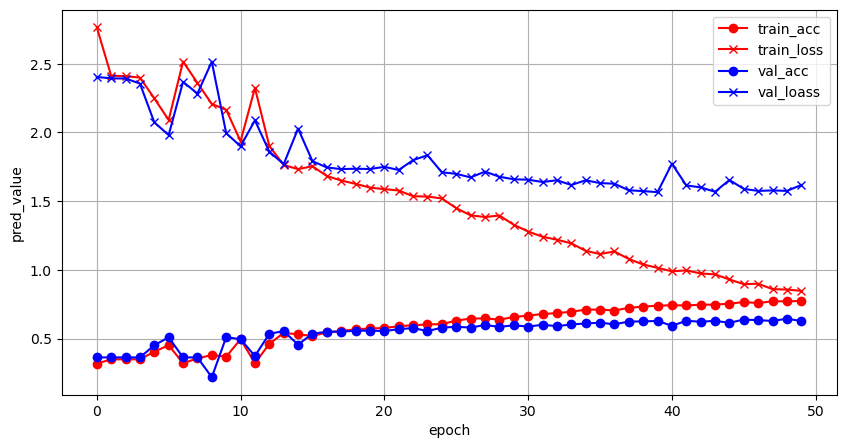

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(x_len, 훈련용_데이터_정확도, marker='o', c="r", label='train_acc');
plt.plot(x_len, 훈련용_데이터_손실, marker='x', c="r", label='train_loss');

plt.plot(x_len, 검증용_데이터_정확도, marker='o', c="b", label='val_acc');
plt.plot(x_len, 검증용_데이터_손실, marker='x', c="b", label='val_loass');

# 그 밖의 그래프에 필요한 요소들을 추가합니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('pred_value')


# 8. 모형 성능 평가

In [31]:
손실, 정확도 = 모형.evaluate(테스트용_X, 테스트용_원핫인코딩_y)

print('\n')
print(f"손실: {손실: .4f}, 정확도: {정확도 * 100: 2.2f}%")

71/71 [==============================] - 4s 51ms/step - loss: 1.5747 - accuracy: 0.6260


손실:  1.5747, 정확도:  62.60%


# 9. 모형 활용(=추론 = 예측)

In [32]:
예측치 = 모형.predict(테스트용_X)

71/71 [==============================] - 5s 51ms/step


In [33]:
pd.DataFrame(예측치) 

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.000405,0.020985,0.001322,0.478135,0.220703,0.000214,0.000434,0.006193,0.061508,0.003436,...,0.013716,0.000532,0.005609,0.006865,0.000256,0.001361,0.000255,0.001973,0.000494,1.527452e-04
1,0.053417,0.122908,0.110763,0.011578,0.018813,0.008305,0.004247,0.000361,0.000705,0.200100,...,0.004703,0.004351,0.020687,0.000466,0.004622,0.000855,0.000624,0.000702,0.000366,6.164941e-03
2,0.092101,0.238543,0.101835,0.004629,0.010213,0.019396,0.002157,0.000089,0.000107,0.125472,...,0.001603,0.003733,0.009572,0.000151,0.001626,0.000180,0.000142,0.000191,0.000099,4.746675e-03
3,0.000002,0.000360,0.000009,0.008090,0.987470,0.000001,0.000002,0.000077,0.000163,0.000019,...,0.000030,0.000003,0.000017,0.000186,0.000001,0.000012,0.000002,0.000005,0.000002,2.271779e-07
4,0.003316,0.004006,0.005365,0.000308,0.000296,0.001148,0.074471,0.000122,0.000188,0.007958,...,0.000661,0.029071,0.006533,0.000140,0.012889,0.003547,0.008677,0.001147,0.002120,5.446680e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,0.000045,0.004046,0.000148,0.802615,0.157282,0.000019,0.000028,0.000894,0.005311,0.000527,...,0.001474,0.000040,0.000940,0.000660,0.000017,0.000118,0.000014,0.000172,0.000035,9.279538e-06
2242,0.000008,0.001184,0.000035,0.976743,0.004992,0.000002,0.000003,0.000132,0.001535,0.000221,...,0.000723,0.000008,0.000508,0.000127,0.000005,0.000021,0.000002,0.000044,0.000010,2.453749e-06
2243,0.000009,0.001307,0.000039,0.975333,0.005410,0.000003,0.000004,0.000143,0.001600,0.000240,...,0.000755,0.000009,0.000544,0.000135,0.000005,0.000023,0.000002,0.000049,0.000011,2.835030e-06
2244,0.000299,0.017481,0.000775,0.531096,0.354343,0.000173,0.000258,0.002342,0.013373,0.002083,...,0.003980,0.000234,0.003092,0.001801,0.000108,0.000357,0.000082,0.000824,0.000125,7.919328e-05


In [34]:
예측치 = 모형.predict(테스트용_X[:40])
print([np.argmax(예측치[i]) for i in range(40)])

2/2 [==============================] - 0s 28ms/step
[3, 9, 1, 4, 20, 3, 3, 3, 3, 3, 1, 4, 1, 3, 1, 8, 4, 3, 19, 3, 8, 3, 3, 3, 1, 3, 4, 13, 1, 3, 3, 1, 4, 3, 19, 4, 19, 1, 16, 3]


In [35]:
print([np.argmax(테스트용_원핫인코딩_y[i]) for i in range(40)])

[3, 10, 1, 4, 4, 3, 3, 3, 3, 3, 5, 4, 1, 3, 1, 11, 23, 3, 19, 3, 8, 3, 3, 3, 9, 3, 4, 6, 10, 3, 3, 10, 20, 1, 19, 4, 40, 1, 4, 3]
